<a href="https://colab.research.google.com/github/dorian-goueytes/L1_P-M1_MIASHS/blob/main/TD_3_boucle_ferm%C3%A9e_integration_sensorimotrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intégration sensorimotrice avec un réseau de neurones

Dans ce TD nous allons construire un réseau de neurones pour modéliser la notion de poursuites oculaires (le fait que les yeux peuvent être mobilisés pour suivre rapidement et avec précision un objet mouvant).

Pour cela nous allons créer un modèle constitué;

- D'une cible mouvante (se déplaçant dans une seule dimension, de gauche à droite)
- De neurones rétiniens activés par la lumière reflétée par l'objet mouvant lorsque celui-ci passe dans leur champs récepteur (la partie du champs visuel dans lequel ces neurones sont sensibles à la lumière).
- De neurones moteurs connectant les neurones rétiniens (qui sont des récepteurs) aux muscles oculaires (qui sont des effecteurs)
- De muscles oculaires pouvant mobiliser l'oeil vers la droite ou vers la gauche



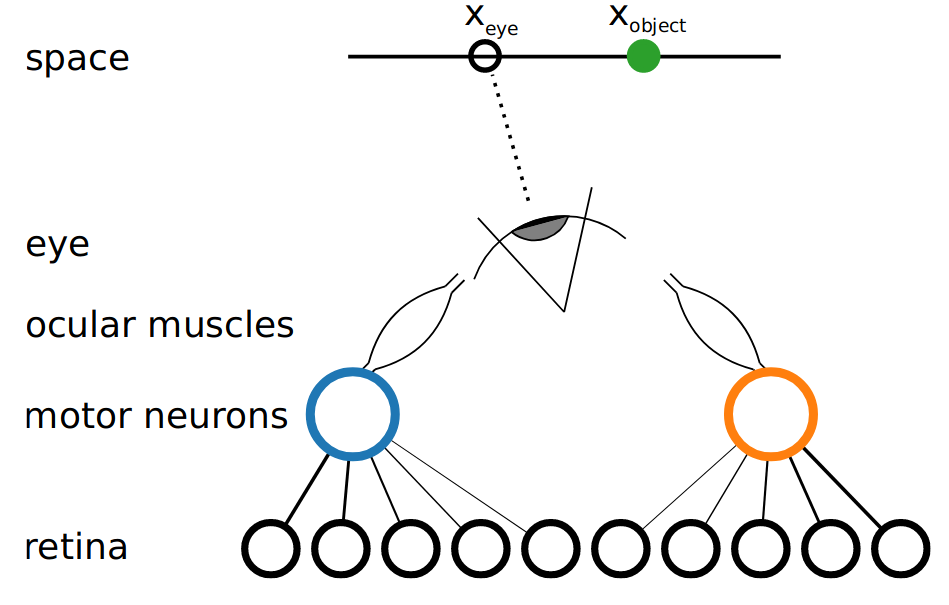

Le code de ce TD est adapté de la publication suivante :

Stimberg, M., Brette, R., & Goodman, D. F. (2019). Brian 2, an intuitive and efficient neural simulator. eLife, 8, e47314. https://doi.org/10.7554/eLife.47314


[https://github.com/brian-team/brian2_paper_examples/blob/master/example_2_eye_movements.ipynb](https://github.com/brian-team/brian2_paper_examples/blob/master/example_2_eye_movements.ipynb)


In [ ]:
# @title Installation des dépendances
!pip install brian2
from brian2 import *
seed(79620)
import plotly.io as pio
pio.renderers.default = 'colab'

In [ ]:
# @title Définition du modèle

def simulate_network(sim_dur = 10, obj_mouv = 500, moto_syn_weight = 0.5, N_ret_neurons = 20, RF_width = 0.1):
  ###################################################
  ## Définit l'objet et sa vélocity, ainsi que l'oeil
  alpha = (1/(50*ms))**2 # characteristic relaxation time is 50 ms
  beta = 1/(50*ms) # friction parameter
  tau_muscle = 20*ms # relaxation time of muscle contraction
  tau_object = obj_mouv*ms # time constant of object movement

  eqs_eye = '''
  dx/dt = velocity : 1
  dvelocity/dt = alpha*(x0-x)-beta*velocity : 1/second
  dx0/dt = -x0/tau_muscle : 1
  dx_object/dt = (noise - x_object)/tau_object:  1
  dnoise/dt = -noise/tau_object + tau_object**-0.5*xi : 1
  '''
  eye = NeuronGroup(1, model=eqs_eye, method='euler')

  ######################################################################################
  ## Définit les neurones moteurs connectant le neurones rétinaux aux muscles oculaires
  taum = 20*ms
  motoneurons = NeuronGroup(2, model= 'dv/dt = -v/taum : 1', threshold = 'v>1',
                          reset = 'v=0', refractory = 5*ms, method='exact')

  ##################################
  ## Construit les synapses motrices
  motosynapses = Synapses(motoneurons, eye, model = 'w : 1', on_pre = 'x0+=w')
  motosynapses.connect() # connects all motoneurons to the eye
  motosynapses.w = [-moto_syn_weight,moto_syn_weight]

  ##############################################
  ## Définit le modèles de neurones de la rétine
  N = N_ret_neurons
  width = RF_width # width of receptive field
  gain = 4.
  eqs_retina = '''
  I = gain*exp(-((x_object-x_eye-x_neuron)/width)**2) : 1
  x_neuron : 1 (constant)
  x_object : 1 (linked) # position of the object
  x_eye : 1 (linked) # position of the eye
  dv/dt = (I-(1+gs)*v)/taum : 1
  gs : 1 # total synaptic conductance
  '''
  retina = NeuronGroup(N, model = eqs_retina, threshold = 'v>1', reset = 'v=0', method='exact')
  retina.v = 'rand()'
  retina.x_eye = linked_var(eye, 'x')
  retina.x_object = linked_var(eye, 'x_object')
  retina.x_neuron = '-1.0 + 2.0*i/(N-1)'

  #################################################################################
  ## Construit les synapses entre les neurones de la rétine et les neurones moteurs
  sensorimotor_synapses = Synapses(retina, motoneurons, model = 'w : 1 (constant)', on_pre = 'v+=w')
  sensorimotor_synapses.connect(j = 'int(x_neuron_pre > 0)')
  sensorimotor_synapses.w = str(N_ret_neurons)+'*abs(x_neuron_pre)/N_pre'


  ###############################################################################################
  ## Création de capteurs pour enregistrer l'activité des neurones, de l'oeil et de l'objet cible
  M = StateMonitor(eye, ('x', 'x0', 'x_object'), record = True)
  S_retina = SpikeMonitor(retina)
  S_motoneurons = SpikeMonitor(motoneurons)

  ######################
  ## Lance la simulation
  SSM_net = Network(eye,motoneurons,retina,sensorimotor_synapses,motosynapses, M, S_retina, S_motoneurons)
  SSM_net.run(sim_dur*second, report='text')

  return M, S_retina, S_motoneurons

def plot_data(M,S_retina, S_motoneurons, N_ret_neurons):
  from plotly import tools
  from plotly.offline import iplot, init_notebook_mode
  import plotly.graph_objs as go
  from plotly import subplots as sub

  N = N_ret_neurons
  fig = sub.make_subplots(4, 1, specs=[[{'rowspan': 2}], [None], [{}], [{}]],
                            shared_xaxes=True, print_grid=False)

  trace = go.Scatter(x=S_retina.t/second,
                    y=S_retina.i,
                    marker={'symbol': 'line-ns', 'line': {'width': 1, 'color':'black'}},
                    mode='markers',
                    name='PAs, neurones de la rétine',
                    showlegend=True)
  fig.append_trace(trace, 1, 1)
  motoneuron_spikes = S_motoneurons.spike_trains()
  trace = go.Scatter(x=motoneuron_spikes[0]/second,
                    y=np.ones(S_motoneurons.count[0])*N,
                    marker={'symbol': 'line-ns', 'line': {'width': 1, 'color':'#1f77b4'},
                            'color':'#1f77b4'},
                    mode='markers',
                    name='PAs, neurone moteur gauche',
                    showlegend=True)
  fig.append_trace(trace, 1, 1)
  trace = go.Scatter(x=motoneuron_spikes[1]/second,
                    y=np.ones(S_motoneurons.count[1])*(N+1),
                    marker={'symbol': 'line-ns', 'line': {'width': 1, 'color':'#ff7f03'},
                            'color':'#ff7f03'},
                    mode='markers',
                    name='PAs, Neurone moteur droit',
                    showlegend=True)
  fig.append_trace(trace, 1, 1)

  trace = go.Scatter(x=M.t/second,
                    y=M.x[0],
                    mode='lines',
                    line={'color': 'black'},
                    name="Position de l"+"'"+"oeil")
  fig.append_trace(trace, 3, 1)
  trace = go.Scatter(x=M.t/second,
                    y=M.x_object[0],
                    mode='lines',
                    line={'color': '#2ca02c'},
                    name='Position de la cible')
  fig.append_trace(trace, 3, 1)

  trace = go.Scatter(x=M.t/second,
                    y=M.x_object[0]-M.x[0],
                    mode='lines',
                    line={'color': 'rgb(255,0,0)'},
                    name='Différence des positions entre oeil et cible',
                    showlegend = True)
  fig.append_trace(trace, 4, 1)



  fig['layout'].update(xaxis1={'showline': False,
                              'zeroline': False,
                              'title': 'time (in s)'},
                      yaxis1={'title': 'neuron index',
                              'showticklabels': False,
                              'showline': True},
                      yaxis2={'tickmode': 'array',
                              'ticktext': ['left', 'right'],
                              'tickvals': [-1, 1],
                              'range': [-1.05, 1.05],
                              'zeroline': True,
                              'showline': True}
                      )
  print('Différence Moyenne entre la position de la cible et des yeux : ', abs(np.mean(M.x_object[0]-M.x[0])))
  iplot(fig)

### Comprendre le modèle et décrire les résultats
Pour cette première étape vous aller lancer le modèle avec ses paramètres par défaut. Votre objectif et de comprendre le fonctionnement du modèle et d'en décrire les résultats

**Q01: Proposez une description de la figure de résultats. Décrivez chaque sous-figure séparément**

**Q02 : En vous basant sur votre description, interprétez les résultats du modèle**

In [ ]:
# @title Simulation de notre réseau de neurones avec ses paramètres par défaut
N = 20
M, S_retina, S_motoneurons = simulate_network()
plot_data(M,S_retina, S_motoneurons, N)

### Capacité de notre modèle à suivre une cible instable
Nous allons dans un premier temps tester si notre modèle de poursuite oculaire est robuste si la stabilité de la cible dans l'espace change

**Q03: Qu'observez-vous lorsque vous manipulez le paramètre "vel_mouv"?**

**Q04: Décrivez les performances du modèle en fonction de "vel_mouv". Les performances du modèle sont-elle stable pour toutes les valeurs de "vel_mouv?**


In [ ]:
# @title Manipulation de la Stabilité de la cible
vel_mouv = 500 # @param {type:"slider", min:10, max:600, step:10}
N = 20
M, S_retina, S_motoneurons = simulate_network(obj_mouv =vel_mouv, N_ret_neurons = N)
plot_data(M,S_retina, S_motoneurons, N)

### Effet du poids de la synapse motrice
Rappel :  Le poids d'une synapse va déterminer dans quel mesure l'activité d'un neurone présynaptique va influencer l'activité post-synaptique. Pour un poids de 0 il n'y a pas de transmission post-synaptique, pour un poids de 1 on observe un couplage parfait.

**Q05: Qu'observez-vous lorsque vous manipulez le paramètre "poids_synaptique"?**

In [ ]:
# @title Manipulation du poids synaptique
vel_mouv = 500 # @param {type:"slider", min:10, max:600, step:10}
poids_synaptique= 0.5 # @param {type:"slider", min:0, max:1, step:0.1}
N = 20
M, S_retina, S_motoneurons = simulate_network(obj_mouv =vel_mouv, N_ret_neurons = N,
                        moto_syn_weight = poids_synaptique)
plot_data(M,S_retina, S_motoneurons, N)

### Manipulation du champs récepteur
Rappel :  Le champs récepteur correspond à la partie de l'espace visuel (ou champ de vision) à laquelle un neurone est sensible. le paramètre "taille_CR" correspond à la taille du champs récepteur de nos neurones rétinaux

**Q06: Qu'observez vous lorsque vous manipulez la taille du champs récepteur"?**

**Q07: Quelles sont les similitudes et les différences par rapport à vos observations lors de la manipulation du poids synaptique?**

**Q08: Connaissez vous des exemples de troubles du système sensorimoteur ressemblant à nos observations pour la manipulation du poids synaptique et celle des champs récepteurs?**

In [ ]:
# @title Manipulation de la taille du champs récepteur
vel_mouv = 500 # @param {type:"slider", min:10, max:600, step:10}
poids_synaptique= 0.5 # @param {type:"slider", min:0, max:1, step:0.1}
taill_CR= 0.1 # @param {type:"slider", min:0, max:0.19, step:0.01}
N = 20
M, S_retina, S_motoneurons = simulate_network(obj_mouv =vel_mouv, N_ret_neurons = N,
                        moto_syn_weight = poids_synaptique, RF_width = taill_CR)
plot_data(M,S_retina, S_motoneurons, N)